**User Input and Image Generation**

Steps with Gradio:
1. Ask User for Image Concepts: Use Gradio to create a text input interface where users can enter their image concepts.
2. Clean User Input: Ensure the prompt is clean of unnecessary spaces or characters.
3. Prompt the Image Generation Agent: Call APIs to generate images using Stable Diffusion XL and DALL-E based on user input.

In [1]:
# Import Dependencies

# For environment variables
import os
from dotenv import load_dotenv

# For dataframes
import pandas as pd

# For image processing and viewing
import base64
import io
from PIL import Image
import matplotlib.pyplot as plt

# For UI
import gradio as gr

# Load dependencies to measure text output
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import common_functions as functions

In [2]:
# Load environment variables.
load_dotenv()

# Store the API key in a variable.
OPEN_AI_API_KEY = os.getenv("OPENAI_API_KEY")
STABILITY_AI_API_KEY = os.getenv("STABILITY_AI_API_KEY")

In [3]:
# Utility to view images for debugging
def view_base64_image(base64_string):
    """Decodes a base64 encoded image and displays it using matplotlib."""

    # Decode the base64 string
    image_data = base64.b64decode(base64_string)

    # Open the image using PIL
    image = Image.open(io.BytesIO(image_data))

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [4]:
# Generate images and assess their quality
def generate_images_with_quality(prompt):
    unique_id = functions.generate_hash(prompt, algorithm='md5')

    cleaned_prompt = functions.clean_user_input(prompt)
    stability_ai_image = functions.base64_to_pil_image(functions.generate_stability_ai_image(STABILITY_AI_API_KEY, cleaned_prompt))
    dalle_image = functions.base64_to_pil_image(functions.call_dalle_api(OPEN_AI_API_KEY, cleaned_prompt))
        
    with open(f"generated_images/{unique_id}_prompt.txt", "w") as f:
        # Write text to the file
        f.write(f'{prompt},{cleaned_prompt}')
        
    stability_ai_image.save(f'generated_images/{unique_id}_stability_ai.jpg')
    dalle_image.save(f'generated_images/{unique_id}_dalle.jpg')

    higher_bleu_model = functions.process_image_record(unique_id)

    return stability_ai_image, dalle_image, higher_bleu_model

In [5]:
def prefer_stability_ai(param):
    functions.update_image_record(param, 'stability_ai')

def prefer_dalle(param):
    functions.update_image_record(param, 'dall-e')

# Create the Gradio interface using Blocks
with gr.Blocks() as demo:
    gr.Markdown("# Text-to-Image Generation")
    gr.Markdown("Input a prompt to generate images using Stability AI and Dall-E.")

    # Input component for text concept
    concept_input = gr.Textbox(label="Enter Image Prompt", placeholder="Describe the image...")

    # Create a submit button
    generate_button = gr.Button("Generate Images")

    winner = gr.Label(label="BLEU Score Choice")

    # Output components for displaying images
    stability_output = gr.Image(type="pil", label="Stability AI Image")
    dalle_output = gr.Image(type="pil", label="Dall-E Image")

    stability_ai_button = gr.Button("I like Stability AI image")
    stability_ai_button.click(
        fn=prefer_stability_ai, 
        inputs=[concept_input],
        outputs=[]
    )    

    dalle_button = gr.Button("I like Dall-E image")
    dalle_button.click(
        fn=prefer_dalle, 
        inputs=[concept_input],
        outputs=[]
    )    

    # Button click event to generate images
    generate_button.click(
        fn=generate_images_with_quality, 
        inputs=concept_input, 
        outputs=[stability_output, dalle_output, winner]
    )

# Launch the interface
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://089cf7e09a3651c5b5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


**Image Evaluation, Relevance Check, and Description Generation**

Steps:
1. Evaluate Image Relevance: Use an LLM to assess whether the generated image is relevant to the prompt.
2. Generate Image Descriptions: Use a classifier to create descriptive summaries of the images.
3. Compare Models: Analyze how each model's output aligns with the user query.

In [6]:
# Loop through records in results to fill in any missing scores
results_df = pd.read_csv('image_generation_results.csv')
for record in results_df["Unique Id"].unique():
    caption = str(results_df[results_df["Unique Id"] == record]["Stability AI Caption"])
    # Only process unprocessed records
    if "NaN" in caption:
        print('processing record')
        functions.process_image_record(record)
    else:
        print('record is already processed')

record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed


In [7]:
def plot_scores(model, reference_captions, generated_captions):
    # Calculate BLEU scores
    bleu_scores = [sentence_bleu([ref.split()], gen.split()) for ref, gen in zip(reference_captions, generated_captions)]

    # Calculate ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(ref, gen) for ref, gen in zip(reference_captions, generated_captions)]
    rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]

    # Prepare data for K-means
    X = np.array(list(zip(bleu_scores, rouge1_scores)))

    # Apply StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply K-means clustering
    n_clusters = 2
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)  # Use scaled data
    labels = kmeans.labels_

    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='plasma', alpha=0.6, edgecolor='k')

    # Annotating points
    for i, txt in enumerate(generated_captions):
        plt.annotate(txt, (X_scaled[i, 0], X_scaled[i, 1]), fontsize=9, alpha=0.7)

    plt.title(f'{model} K-means Clustering of BLEU and ROUGE Scores', fontsize=14)
    plt.xlabel('Scaled BLEU Score', fontsize=12)
    plt.ylabel('Scaled ROUGE-1 Score', fontsize=12)
    plt.colorbar(scatter, label='Cluster Label')
    plt.grid(True)
    plt.tight_layout()

    # Show or save the plot
    plt.show()  # or plt.savefig('kmeans_clustering_plot.png')
    plt.savefig(f'kmeans_clustering_plot_{model}.png')



/Users/elizayoung/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/elizayoung/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/elizayoung/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or

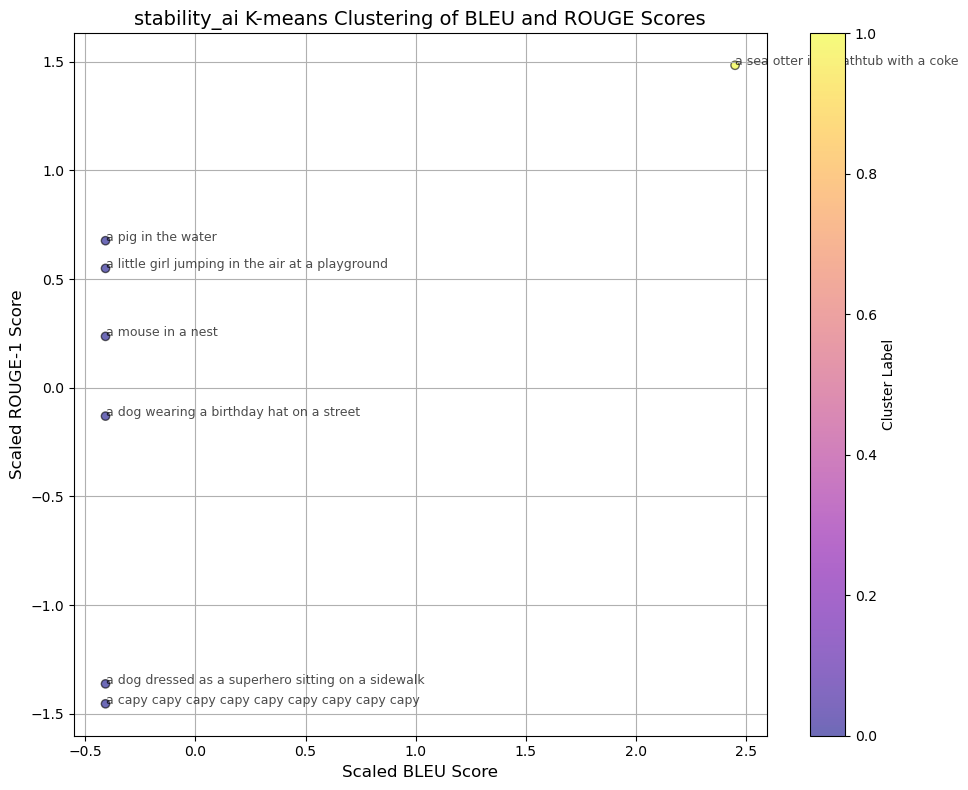

<Figure size 640x480 with 0 Axes>

In [8]:
df = pd.read_csv('image_generation_results.csv')

# Create array of reference prompts
reference_captions = df["Prompt"].tolist()

# Create array of generated captions
generated_captions = df["Stability AI Caption"].tolist()

plot_scores('stability_ai', reference_captions, generated_captions)

/Users/elizayoung/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/elizayoung/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/elizayoung/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or

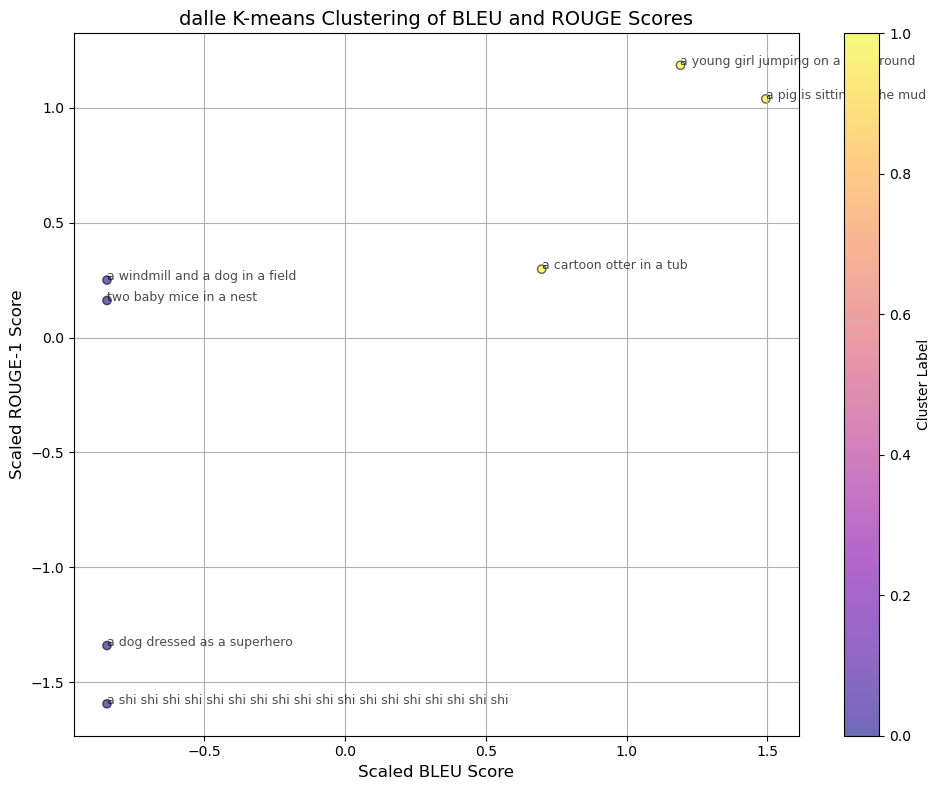

<Figure size 640x480 with 0 Axes>

In [9]:
# Create array of generated captions
generated_captions = df["Dall-E Caption"].tolist()

plot_scores('dalle', reference_captions, generated_captions)

Output results to file

In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import re

# Load dataframe
df = pd.read_csv('image_generation_results.csv')

# Check for 'User Preference'
if 'User Preference' not in df.columns:
    raise ValueError("User Preference column not found in the DataFrame.")

# Print sample of the ROUGE columns for debugging
print("Sample data from 'Stability AI Rouge':")
print(df['Stability AI Rouge'].head())
print("Sample data from 'Dall-E Rouge':")
print(df['Dall-E Rouge'].head())

# Flatten ROUGE score tuples if needed
def flatten_rouge(record):
    try:
        # Extract the numbers from the string using regex
        matches = re.findall(r'precision=([\d.]+), recall=([\d.]+), fmeasure=([\d.]+)', record)
        if matches:
            precision, recall, fmeasure = matches[0]
            return {'fmeasure1': float(fmeasure), 'fmeasure2': float(precision), 'fmeasureL': float(recall)}
        else:
            return {'fmeasure1': None, 'fmeasure2': None, 'fmeasureL': None}
    except Exception as e:
        print(f"Error processing record: {record}, Error: {e}")
        return {'fmeasure1': None, 'fmeasure2': None, 'fmeasureL': None}

# Extract and flatten ROUGE scores
rouge_stability = pd.DataFrame(df['Stability AI Rouge'].apply(flatten_rouge).tolist(), index=df.index)
rouge_dalle = pd.DataFrame(df['Dall-E Rouge'].apply(flatten_rouge).tolist(), index=df.index)

print("Flattened Stability AI Rouge scores:")
print(rouge_stability.head())
print("Flattened Dall-E Rouge scores:")
print(rouge_dalle.head())

# Print shapes of the flattened scores
print(f"Stability AI Rouge shape: {rouge_stability.shape}")
print(f"Dall-E Rouge shape: {rouge_dalle.shape}")

# Ensure we have the correct number of columns
if rouge_stability.shape[1] != 3 or rouge_dalle.shape[1] != 3:
    raise ValueError("Expected 3 columns for ROUGE scores but got different numbers.")

# Add flattened scores back to DataFrame
df[['Stability AI Rouge1', 'Stability AI Rouge2', 'Stability AI RougeL']] = rouge_stability
df[['Dall-E Rouge1', 'Dall-E Rouge2', 'Dall-E RougeL']] = rouge_dalle

# Select features and target variable
features = ['Stability AI Rouge1', 'Stability AI Rouge2', 'Stability AI RougeL',
            'Dall-E Rouge1', 'Dall-E Rouge2', 'Dall-E RougeL',
            'Stability AI BLEU', 'Dall-E BLEU']

# Remove any rows with NaN values in features
X = df[features].dropna()
# Check for NaN values in target variable and handle them
y = df.loc[X.index, 'User Preference']

# Remove rows in X and y where y is NaN
X = X[y.notna()]
y = y.dropna()

# Check if X and y are empty
if X.empty or y.empty:
    print("No data available for training.")
    print(f"Shape of features: {X.shape}, Shape of target: {y.shape}")
else:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fill NaN values in features only (if any)
    X_train = X_train.fillna(X_train.mean())

    # Verify after cleaning
    print("NaN values in X_train after cleaning:", X_train.isnull().sum())
    print("NaN values in y_train after cleaning:", y_train.isnull().sum())

    # Fit Random Forest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))



Sample data from 'Stability AI Rouge':
0    {'rouge1': Score(precision=0.1, recall=0.06666...
1    {'rouge1': Score(precision=0.8888888888888888,...
2    {'rouge1': Score(precision=0.4444444444444444,...
3    {'rouge1': Score(precision=0.6, recall=0.66666...
4    {'rouge1': Score(precision=0.8, recall=0.57142...
Name: Stability AI Rouge, dtype: object
Sample data from 'Dall-E Rouge':
0    {'rouge1': Score(precision=0.75, recall=0.4, f...
1    {'rouge1': Score(precision=0.6666666666666666,...
2    {'rouge1': Score(precision=0.05263157894736842...
3    {'rouge1': Score(precision=0.8571428571428571,...
4    {'rouge1': Score(precision=0.7142857142857143,...
Name: Dall-E Rouge, dtype: object
Flattened Stability AI Rouge scores:
   fmeasure1  fmeasure2  fmeasureL
0   0.080000   0.100000   0.066667
1   0.888889   0.888889   0.888889
2   0.444444   0.444444   0.444444
3   0.631579   0.600000   0.666667
4   0.666667   0.800000   0.571429
Flattened Dall-E Rouge scores:
   fmeasure1  fmeasure2  f

<Figure size 1200x800 with 0 Axes>

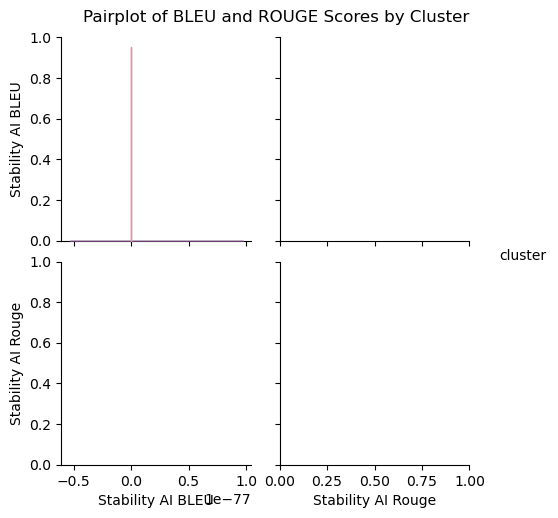

In [12]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Load your DataFrame
df = pd.read_csv('image_generation_results.csv')

# Vectorize the captions
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['Stability AI Caption'])

# Convert sparse matrix to a DataFrame and keep track of the original indices
X_df = pd.DataFrame(X.toarray())
X_df['original_index'] = df.index  # Keep track of the original index

# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_df.drop('original_index', axis=1))

# Initialize the 'cluster' column in df with NaN
df['cluster'] = np.nan

# Assign cluster labels to the correct indices
for i in range(len(cluster_labels)):
    df.loc[X_df['original_index'].iloc[i], 'cluster'] = cluster_labels[i]

# Ensure BLEU and ROUGE scores are numeric
df['Stability AI BLEU'] = pd.to_numeric(df['Stability AI BLEU'], errors='coerce')
df['Stability AI Rouge'] = pd.to_numeric(df['Stability AI Rouge'], errors='coerce')

# Plot the results
plt.figure(figsize=(12, 8))
sns.pairplot(df, hue='cluster', vars=['Stability AI BLEU', 'Stability AI Rouge'], dropna=True)
plt.suptitle('Pairplot of BLEU and ROUGE Scores by Cluster', y=1.02)
plt.show()